In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import re

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hafez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hafez\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
netl = WordNetLemmatizer()

def nltk_tag_pos(tag):   
    #adapted from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    if tag[0]=='J':
        return wordnet.ADJ
    elif tag[0]=='V':
        return wordnet.VERB
    elif tag[0]=='N':
        return wordnet.NOUN
    elif tag[0]=='R':
        return wordnet.ADV
    else:          
        return wordnet.NOUN #noun is default lemmatize POS
    
train_text_POS = [nltk.pos_tag(i) for i in train_text]    
train_text = [[wnetl.lemmatize(i[0],nltk_tag_pos(i[1]))  if i[0] != 'us' else i[0] for i in j] for j in train_text_POS]
traindf['cleaned_tweet_length'] = [len(w) for w in train_text]
train_text = [' '.join(train_text[i]) for i in range(len(train_text))]

In [47]:
sw = set(nltk.corpus.stopwords.words('english'))

def nltk_tag_pos(tag):   
    #adapted from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    if tag[0]=='J':
        return wordnet.ADJ
    elif tag[0]=='V':
        return wordnet.VERB
    elif tag[0]=='N':
        return wordnet.NOUN
    elif tag[0]=='R':
        return wordnet.ADV
    else:          
        return wordnet.NOUN #noun is default lemmatize POS

def clean(text, stopwords):
    # remove tags like <tab>    
    text = re.sub(r'<[^<>]*>', ' ', text)  
    # split text on whitespace
    text_list = text.split()
    text_words = []
    wnetl = WordNetLemmatizer()
    punctuation = set(string.punctuation)
    
    # keep #tags and @mentions 
    ## punctuation.remove("#")
    ## punctuation.remove("@")

    text_POS = nltk.pos_tag(text_list)
#     print(text_POS)
    text_list = [wnetl.lemmatize(i[0],nltk_tag_pos(i[1])) for i in text_POS]
    
    for word in text_list:
        # remove punctuation marks at the beginning  
        # of each word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]
        
        # remove punctuation marks at the end of each word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]
        
        # a rule to eliminate most urls 
        if len(word) > 0 and "/" not in word:
            # eliminate stopwords 
            if word.lower() not in stopwords:
                # append the word to the text_words list
                text_words.append(word.lower())
        cleaner_text = " ".join(text_words)
    return cleaner_text

In [ ]:
def ingest_and_clean_data():
    from pathlib import Path

    file_list_pos = [path for path in Path('imdb').rglob('*/pos/*.txt')]
    file_list_neg = [path for path in Path('imdb').rglob('*/neg/*.txt')]

    corpus_positive = [open(f, encoding="utf8").read() for f in file_list_pos]
    corpus_negative = [open(f, encoding="utf8").read() for f in file_list_neg]

    df = pd.DataFrame(corpus_positive, columns=['text'])
    df['sentiment'] = 'pos'

    df2 = pd.DataFrame(corpus_negative, columns=['text'])
    df2['sentiment'] = 'neg'

    df = df.append(df2)

    df['length'] = df.text.str.len()
    df = df[df.length >= 100]
    df.drop(['length'], axis=1, inplace=True)

    print(df.iloc[0])
    df.to_pickle('raw_reviews.pkl')
    df['text'] = df['text'].apply(clean, stopwords=sw)
    print(df.iloc[0])

    df.to_pickle('reviews.pkl')

In [3]:
df2 = pd.read_pickle('raw_reviews.pkl')
df2

,text,sentiment
0,I went and saw this movie last night after bei...,pos
1,Actor turned director Bill Paxton follows up h...,pos
2,As a recreational golfer with some knowledge o...,pos
3,"I saw this film in a sneak preview, and it is ...",pos
4,Bill Paxton has taken the true story of the 19...,pos
...,...,...
24995,"Towards the end of the movie, I felt it was to...",neg
24996,This is the kind of movie that my enemies cont...,neg
24997,I saw 'Descent' last night at the Stockholm Fi...,neg
24998,Some films that you pick up for a pound turn o...,neg


In [48]:
df = pd.read_pickle('raw_reviews.pkl')
df['text'] = df['text'].apply(clean, stopwords=sw)
print(df.iloc[0])

df.to_pickle('reviews.pkl')

text         go saw movie last night coax friend mine i'll ...
sentiment                                                  pos
Name: 0, dtype: object


In [ ]:
# ingest_and_clean_data()

In [2]:
df = pd.read_pickle('reviews.pkl')
# df['sentiment']=(df['sentiment']=='pos').astype(int)
df

,text,sentiment
0,go saw movie last night coax friend mine i'll ...,pos
1,actor turn director bill paxton follow promisi...,pos
2,recreational golfer knowledge sport's history ...,pos
3,saw film sneak preview delightful cinematograp...,pos
4,bill paxton take true story 1913 us golf open ...,pos
...,...,...
24995,towards end movie felt technical felt like cla...,neg
24996,kind movie enemy content watch time bloody tru...,neg
24997,saw descent last night stockholm film festival...,neg
24998,film pick pound turn rather good 23rd century ...,neg


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=123)

Trying Multinomial Naive Bayes

The train set accuracy is 0.856799735713297


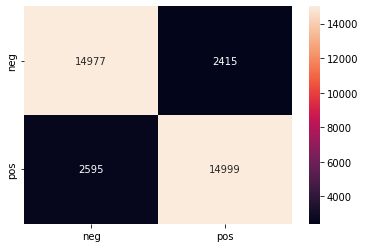

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score, cross_val_predict

pipe_nb = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', MultinomialNB())])

pipe_nb.fit(X_train, y_train)

cv_acc_score = np.mean(cross_val_score(pipe_nb, X_train, y_train, scoring='accuracy'))

# predicted_sentiment = pipe_nb.predict(X_test)

predicted_sentiment_train = cross_val_predict(pipe_nb,X_train,y_train)



cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


print(f"The train set accuracy is {cv_acc_score}")
# print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

In [54]:
len(pipe_nb.steps[0][1].get_feature_names())

/mnt/c/users/chris/desktop/atomprojects/cs4448/cs4448/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


82560

Trying Random Forest

The train set accuracy is 0.8469388158555521


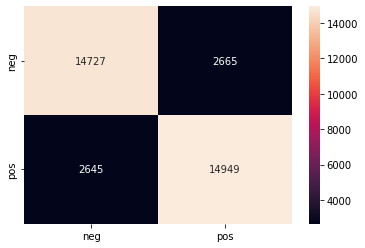

In [55]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', RandomForestClassifier(n_jobs=5))])

pipe_rf.fit(X_train, y_train)

cv_acc_score = np.mean(cross_val_score(pipe_rf, X_train, y_train, scoring='accuracy'))

# predicted_sentiment = pipe_nb.predict(X_test)

predicted_sentiment_train = cross_val_predict(pipe_rf,X_train,y_train)

cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

print(f"The train set accuracy is {cv_acc_score}")
# print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

Trying XGBoost

The train set accuracy is 0.8472529667411866


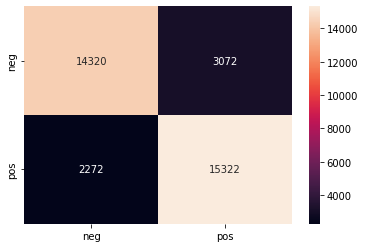

In [56]:
from xgboost import XGBClassifier
pipe_xgb = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")),
                     ('clf', XGBClassifier(objective='binary:logistic', use_label_encoder=True,eval_metric='error',n_jobs=5))])


import warnings
warnings.filterwarnings("ignore") #ignore lot of xgb UserWarnings that don't affect results

pipe_xgb.fit(X_train, y_train)

cv_acc_score = np.mean(cross_val_score(pipe_xgb, X_train, y_train, scoring='accuracy'))

# predicted_sentiment = pipe_nb.predict(X_test)
predicted_sentiment_train = cross_val_predict(pipe_xgb,X_train,y_train)
warnings.filterwarnings("default")

cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

print(f"The train set accuracy is {cv_acc_score}")
# print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

## After cross-validation on the Training set: 
Multinomial Naive Bayes had the best accuracy across the 5 cross-validation folds (approximately 85.6%).  

Hyperparameter Tuning Naive Bayes

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'tfidf__min_df': (0, 0.1, 0.25),
    'tfidf__max_df': (0.5, 0.75, 1),
#     'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': (1, 1e-2, 1e-3)
}

grid_search = GridSearchCV(pipe_nb, parameters, cv=5,n_jobs=5)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)
predicted_sentiment_train = grid_search.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score
print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
print(f"Best Parameters: {grid_search.best_params_}")

Tuning TfidfVectorizer "max_feature" parameter:

In [ ]:
parameters = {
    'tfidf__max_features': range(5000,80001,5000)
}

grid_search = GridSearchCV(grid_search.best_estimator_, parameters, cv=3,n_jobs=5,scoring='accuracy')
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
plt.plot(grid_search.param_grid['tfidf__max_features'],grid_search.cv_results_['mean_fit_time'],'b-')
plt.plot(grid_search.param_grid['tfidf__max_features'],grid_search.cv_results_['mean_score_time'],'g-')
plt.xlabel('TfidfVectorizer max_features')
plt.ylabel('Cross Validation Computation Time')
plt.legend(['Fit','Score'])
plt.show()

plt.plot(grid_search.param_grid['tfidf__max_features'],grid_search.cv_results_['mean_score_time'])
plt.xlabel('TfidfVectorizer max_features')
plt.ylabel('Cross Validation Score Time')
plt.show()

plt.plot(grid_search.param_grid['tfidf__max_features'],grid_search.cv_results_['mean_fit_time'])
plt.xlabel('TfidfVectorizer max_features')
plt.ylabel('Cross Validation Fit Time')
plt.show()

In [ ]:
plt.plot(grid_search.param_grid['tfidf__max_features'],grid_search.cv_results_['mean_test_score'])
plt.xlabel('TfidfVectorizer max_features')
plt.ylabel('Cross Validation Accuracy')
plt.show()

### Not sure if these make sense - Let me know what you think

In [ ]:
accuracy_gain = grid_search.cv_results_['mean_test_score'] - np.array([0,
                                                                       *grid_search.cv_results_['mean_test_score'][0:len(grid_search.cv_results_['mean_test_score'])-1]])

#Elbow method on this plot to determine optimal number of features based on diminishing accuracy gains?
plt.plot(grid_search.param_grid['tfidf__max_features'][1:], accuracy_gain[1:])
plt.xlabel('TfidfVectorizer max_features')
plt.ylabel('Increase in Accuracy')
plt.show()


Hyperparameter Tuning Random Forest

parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': (50, 100, 150, 200)
}

grid_search = GridSearchCV(pipe_rf, parameters, cv=5, n_jobs=12)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = grid_search.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

print(f"Best Parameters: {grid_search.best_params_}")

Hyperparameter Tuning XGBoost

parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': (50, 100, 150, 200)
}

grid_search = GridSearchCV(pipe_xgb, parameters, cv=5)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = grid_search.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

print(f"Best Parameters: {grid_search.best_params_}")

In [4]:
from datasets import Dataset
dataset = Dataset.from_pandas(df2.rename(columns={'sentiment':'labels'}))

In [5]:
dataset = dataset.remove_columns('__index_level_0__')

In [6]:
from datasets import DatasetDict

train_test = dataset.train_test_split(test_size=0.3)

raw_datasets = DatasetDict({
    'train': train_test['train'],
    'test': train_test['test']})

In [8]:
from transformers import LongformerForSequenceClassification, LongformerTokenizer

model_name = "allenai/longformer-base-4096"
model = LongformerForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = LongformerTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight'

In [9]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(200))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(200))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

100%|██████████| 15/15 [00:20<00:00,  1.35s/ba]


In [10]:
from transformers import TrainingArguments
from transformers import Trainer


training_args = TrainingArguments("train_test", per_device_train_batch_size=2, per_device_eval_batch_size=2)
trainer = Trainer(
    model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `LongformerForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 200
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 300
  0%|          | 0/300 [00:00<?, ?it/s]Initializing global attention on CLS token...


KeyError: 'loss'